In [ ]:
#@title Packages

## General
import os
from pathlib import Path
import pickle

## Data Analysis 
import pandas as pd
import numpy as np

## Torch Specific
# !pip install torchvision
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader




In [ ]:
#@title Install Dependencies

'''
From Tutorial:
https://www.learnpytorch.io/06_pytorch_transfer_learning/
'''


# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine


## Plot Loss Curves
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

In [ ]:
# configure data paths

try:
  from google.colab import drive
  drive.mount('/content/drive')
  train_path = '/content/drive/MyDrive/NN and DL/projects/Released_Data/train'
  test_path = '/content/drive/MyDrive/NN and DL/projects/Released_Data/test'  

except:
  train_path = '/content/train'
  test_path = '/content/test'


train_dog = train_path + '/dog'
train_bird = train_path + '/bird'
train_rep = train_path + '/reptile' 

test_dog = test_path + '/dog'
test_bird = test_path + '/bird'
test_rep = test_path + '/reptile' 



In [ ]:
# put on gpu if available 
device = "cuda" if torch.cuda.is_available() else "cpu"
device
if device=="cuda":
  torch.cuda.empty_cache()

  

In [ ]:
!pip install --upgrade torchvision

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4345 | train_acc: 0.0333 | test_loss: 3.2126 | test_acc: 0.1120
Epoch: 2 | train_loss: 3.2519 | train_acc: 0.0891 | test_loss: 3.0424 | test_acc: 0.1733
Epoch: 3 | train_loss: 3.1094 | train_acc: 0.1420 | test_loss: 2.8881 | test_acc: 0.2844
Epoch: 4 | train_loss: 2.9946 | train_acc: 0.1803 | test_loss: 2.7656 | test_acc: 0.2896
Epoch: 5 | train_loss: 2.8988 | train_acc: 0.2267 | test_loss: 2.6544 | test_acc: 0.3472
Epoch: 6 | train_loss: 2.7831 | train_acc: 0.2687 | test_loss: 2.5147 | test_acc: 0.4515
Epoch: 7 | train_loss: 2.6958 | train_acc: 0.3196 | test_loss: 2.4310 | test_acc: 0.4490
Epoch: 8 | train_loss: 2.6155 | train_acc: 0.3529 | test_loss: 2.3084 | test_acc: 0.5294
Epoch: 9 | train_loss: 2.5211 | train_acc: 0.3785 | test_loss: 2.2152 | test_acc: 0.5928
Epoch: 10 | train_loss: 2.4390 | train_acc: 0.4309 | test_loss: 2.1157 | test_acc: 0.5850
Epoch: 11 | train_loss: 2.3733 | train_acc: 0.4414 | test_loss: 2.0462 | test_acc: 0.6495
Epoch: 12 | train_l

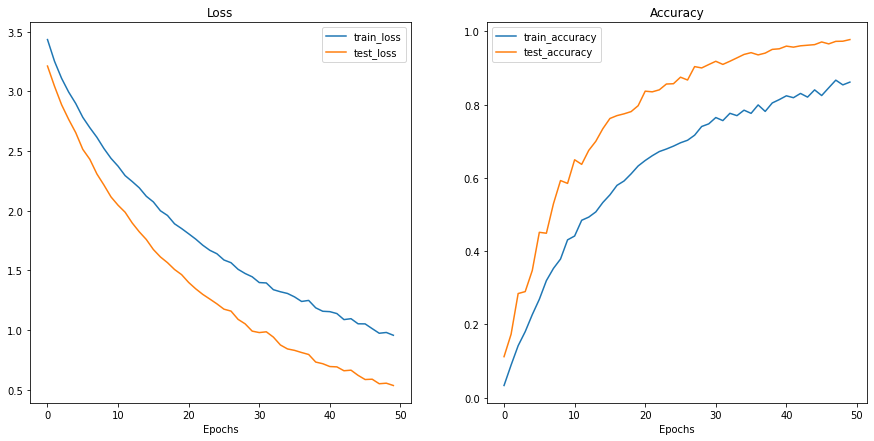

In [ ]:
#@title Reptile


batch_size = 1

# Get a set of pretrained model weights
weights = torchvision.models.ResNet50_Weights.DEFAULT.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet

# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()

# Create training and testing DataLoaders as well as get a list of class names
train_rep_dl, test_rep_dl, rep_classes = data_setup.create_dataloaders(
                                                            train_dir=train_rep,
                                                            test_dir=test_rep,
                                                            transform=auto_transforms,#use manual transforms so its the same in ensemble
                                                            batch_size=32) # set mini-batch size to 32



# model construction

# import model
model = torchvision.models.resnet50(weights=weights).to(device)

for child in model.children():
    for param in child.parameters():
        param.requires_grad = False


# configure output
in_ftrs = model.fc.in_features
out_fts = len(rep_classes) # DOG CLASSES HERE, OBV NEED TO CHANGE !!!
model.fc = nn.Linear(in_ftrs, out_fts)

# train !
batch_size = 32
learning_rate = 0.001
epochs = 50

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                    train_dataloader=train_rep_dl,
                    test_dataloader=test_rep_dl,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=epochs,
                    device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

# print 
best_acc = max(results['test_acc'])
print(f'Best training Accuracy: {best_acc}')

# Plot the loss curves of our model
plot_loss_curves(results)
print('\n')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4253 | train_acc: 0.0497 | test_loss: 3.2573 | test_acc: 0.0912
Epoch: 2 | train_loss: 3.2305 | train_acc: 0.0973 | test_loss: 3.0452 | test_acc: 0.1583
Epoch: 3 | train_loss: 3.0879 | train_acc: 0.1404 | test_loss: 2.9012 | test_acc: 0.2408
Epoch: 4 | train_loss: 2.9881 | train_acc: 0.1752 | test_loss: 2.7766 | test_acc: 0.3058
Epoch: 5 | train_loss: 2.8681 | train_acc: 0.2228 | test_loss: 2.6934 | test_acc: 0.4109
Epoch: 6 | train_loss: 2.7724 | train_acc: 0.2838 | test_loss: 2.5412 | test_acc: 0.3724
Epoch: 7 | train_loss: 2.6895 | train_acc: 0.2987 | test_loss: 2.4426 | test_acc: 0.4334
Epoch: 8 | train_loss: 2.6100 | train_acc: 0.3381 | test_loss: 2.3726 | test_acc: 0.4795
Epoch: 9 | train_loss: 2.4922 | train_acc: 0.3678 | test_loss: 2.2829 | test_acc: 0.5809
Epoch: 10 | train_loss: 2.4447 | train_acc: 0.4144 | test_loss: 2.1422 | test_acc: 0.5973
Epoch: 11 | train_loss: 2.3616 | train_acc: 0.4477 | test_loss: 2.0712 | test_acc: 0.6270
Epoch: 12 | train_l

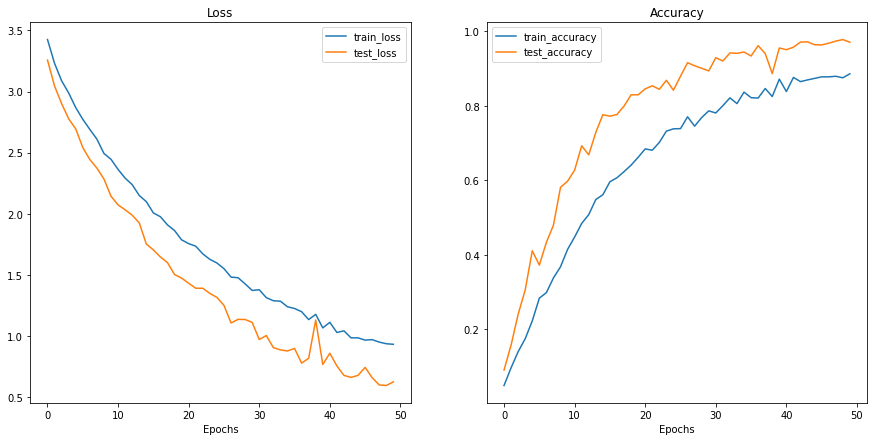

In [ ]:
#@title Bird


batch_size = 1

# Get a set of pretrained model weights
weights = torchvision.models.ResNet50_Weights.DEFAULT.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet

# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()

# Create training and testing DataLoaders as well as get a list of class names
train_bird_dl, test_bird_dl, bird_classes = data_setup.create_dataloaders(
                                                            train_dir=train_bird,
                                                            test_dir=test_bird,
                                                            transform=auto_transforms,#use manual transforms so its the same in ensemble
                                                            batch_size=32) # set mini-batch size to 32



# model construction

# import model
model = torchvision.models.resnet50(weights=weights).to(device)

for child in model.children():
    for param in child.parameters():
        param.requires_grad = False


# configure output
in_ftrs = model.fc.in_features
out_fts = len(bird_classes) # DOG CLASSES HERE, OBV NEED TO CHANGE !!!
model.fc = nn.Linear(in_ftrs, out_fts)

# train !
batch_size = 32
learning_rate = 0.001
epochs = 50

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                    train_dataloader=train_bird_dl,
                    test_dataloader=test_bird_dl,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=epochs,
                    device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

# print 
best_acc = max(results['test_acc'])
print(f'Best training Accuracy: {best_acc}')

# Plot the loss curves of our model
plot_loss_curves(results)
print('\n')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.3880 | train_acc: 0.0365 | test_loss: 3.1831 | test_acc: 0.1134
Epoch: 2 | train_loss: 3.1874 | train_acc: 0.0973 | test_loss: 2.9793 | test_acc: 0.1969
Epoch: 3 | train_loss: 3.0535 | train_acc: 0.1483 | test_loss: 2.8473 | test_acc: 0.2209
Epoch: 4 | train_loss: 2.9442 | train_acc: 0.1938 | test_loss: 2.7038 | test_acc: 0.3241
Epoch: 5 | train_loss: 2.8366 | train_acc: 0.2349 | test_loss: 2.5959 | test_acc: 0.3803
Epoch: 6 | train_loss: 2.7400 | train_acc: 0.2871 | test_loss: 2.4620 | test_acc: 0.4448
Epoch: 7 | train_loss: 2.6427 | train_acc: 0.3218 | test_loss: 2.3572 | test_acc: 0.4950
Epoch: 8 | train_loss: 2.5479 | train_acc: 0.3668 | test_loss: 2.2489 | test_acc: 0.5886
Epoch: 9 | train_loss: 2.4603 | train_acc: 0.4022 | test_loss: 2.1743 | test_acc: 0.5388
Epoch: 10 | train_loss: 2.3864 | train_acc: 0.4226 | test_loss: 2.0876 | test_acc: 0.6050
Epoch: 11 | train_loss: 2.3286 | train_acc: 0.4387 | test_loss: 1.9846 | test_acc: 0.6324
Epoch: 12 | train_l

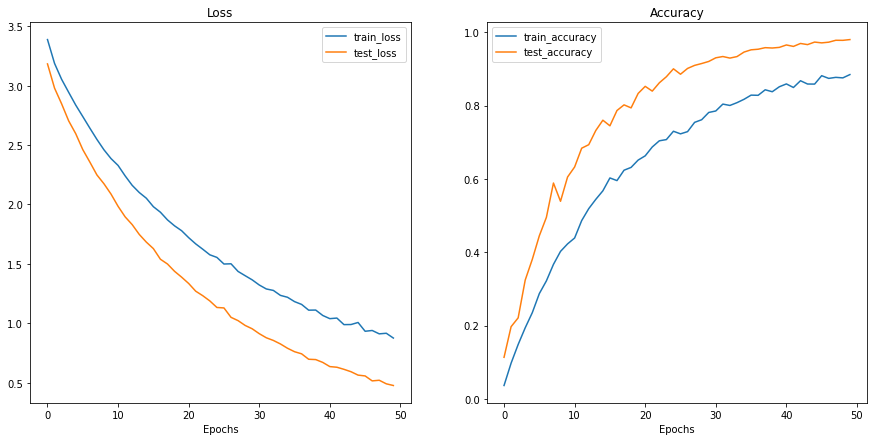

In [ ]:
#@title Dog


batch_size = 1

# Get a set of pretrained model weights
weights = torchvision.models.ResNet50_Weights.DEFAULT.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet

# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()

# Create training and testing DataLoaders as well as get a list of class names
train_dog_dl, test_dog_dl, dog_classes = data_setup.create_dataloaders(
                                                            train_dir=train_dog,
                                                            test_dir=test_dog,
                                                            transform=auto_transforms,#use manual transforms so its the same in ensemble
                                                            batch_size=32) # set mini-batch size to 32



# model construction

# import model
model = torchvision.models.resnet50(weights=weights).to(device)

for child in model.children():
    for param in child.parameters():
        param.requires_grad = False


# configure output
in_ftrs = model.fc.in_features
out_fts = len(dog_classes) # DOG CLASSES HERE, OBV NEED TO CHANGE !!!
model.fc = nn.Linear(in_ftrs, out_fts)

# train !
batch_size = 32
learning_rate = 0.001
epochs = 50

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                    train_dataloader=train_dog_dl,
                    test_dataloader=test_dog_dl,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=epochs,
                    device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

# print 
best_acc = max(results['test_acc'])
print(f'Best training Accuracy: {best_acc}')

# Plot the loss curves of our model
plot_loss_curves(results)
print('\n')